<h1><center>Quantium Data Analytics Virtual Experience Program</center></h1>

### Task 2

## Experimentation and uplift testing

Extend your analysis from Task 1 to help you identify benchmark stores that allow you to test the impact of the trial store layouts on customer sales.

**Here is the background information on your task**

You are part of Quantium’s retail analytics team and have been approached by your client, the Category Manager for Chips, has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.

**Here is your task**

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

To get started use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store. 

This can be broken down by:
- total sales revenue
- total number of customers
- average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

In [1]:
#   Importing the necessary libraries/modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime
import xlrd
%matplotlib inline

#   Ignoring any warnings.

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
qvi_data=pd.read_csv("QVI_data.csv")    #   Reading the CSV file into a pandas.DataFrame.
qvi_data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


In [3]:
qvi_data.info() #    Getting a concise summary of the pandas.DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
qvi_data.isnull().sum() #   Checking for any null values in the pandas.DataFrame.

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

We'll start by assigning a control store to every trial store, which were stores 77, 86 and 88, because we want to find stores that similar attributes to that of the trial stores prior to the entire duration of recorded sales. This way, we can accurately deduce if a particular store has increased its sales during the recorded duration or not.

Firstly, we need to aggregate some statistics about the stores for each recorded month over the entire duration of sales. We can start by finding the total sales for each month during the entire recorded duration, for each store.

In [5]:
qvi_data["YEAR_MONTH"]=pd.to_datetime(qvi_data["DATE"]).dt.to_period("M")   #   Storing the year and month of the recorded duration in a separate column.
qvi_data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,2018-12
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,2018-10
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,2018-10
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,2018-10


In [6]:
total_sales=qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["TOT_SALES"].sum()    #   Grouping the pandas.DataFrame by the STORE_NBR and YEAR_MONTH column, and summing up the total sales for them.
total_sales=total_sales.to_frame()  #   Converting the pandas.Series to a pandas.DataFrame.
total_sales

TOT_SALES
STORE_NBR YEAR_MONTH           
1         2018-07         206.9
          2018-08         176.1
          2018-09         278.8
          2018-10         188.1
          2018-11         192.6
...                         ...
272       2019-02         395.5
          2019-03         442.3
          2019-04         445.1
          2019-05         314.6
          2019-06         312.1

[3169 rows x 1 columns]

Likewise, we can also count the number of unique customers for for each month during the entire recorded duration, for each store.

In [7]:
total_customers=qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["LYLTY_CARD_NBR"].nunique()   #   Grouping the pandas.DataFrame by the STORE_NBR and YEAR_MONTH column, and counting the unique number of customers for them.
total_customers=total_customers.to_frame()  #   Converting the pandas.Series to a pandas.DataFrame.
total_customers

LYLTY_CARD_NBR
STORE_NBR YEAR_MONTH                
1         2018-07                 49
          2018-08                 42
          2018-09                 59
          2018-10                 44
          2018-11                 46
...                              ...
272       2019-02                 45
          2019-03                 50
          2019-04                 54
          2019-05                 34
          2019-06                 34

[3169 rows x 1 columns]

Additionally, we can also find the number of transactions per customer for each recorded month by diving the count of the number of unique transactions and the count of the number of unique customers for each store.

In [8]:
transactions_per_customer=qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["TXN_ID"].nunique()/qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["LYLTY_CARD_NBR"].nunique()   #   Grouping the pandas.DataFrame by the STORE_NBR and YEAR_MONTH column, and counting the unique number of transactions per customer for them.
transactions_per_customer=transactions_per_customer.to_frame()  #   Converting the pandas.Series to a pandas.DataFrame.
transactions_per_customer

0
STORE_NBR YEAR_MONTH          
1         2018-07     1.061224
          2018-08     1.023810
          2018-09     1.050847
          2018-10     1.022727
          2018-11     1.021739
...                        ...
272       2019-02     1.066667
          2019-03     1.060000
          2019-04     1.018519
          2019-05     1.176471
          2019-06     1.088235

[3169 rows x 1 columns]

In [9]:
dataframe_list=[total_sales, total_customers, transactions_per_customer]    #   Creating a list of all the pandas.DataFrames.
dataframe=pd.concat(dataframe_list, axis=1) #   Concatenating all the pandas.DataFrames into one.
dataframe.columns=["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"] #   Renaming the columns of the pandas.DataFrame.
dataframe

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR YEAR_MONTH                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3169 rows x 3 columns]

In [10]:
dataframe.isnull().sum() #   Checking for any null values in the pandas.DataFrame.

TOT_SALES       0
TOT_CUST        0
TXN_PER_CUST    0
dtype: int64

Since the dataset contains transaction details of many stores, there may be some stores that did not record sales for the entire duration.

In [11]:
recorded_stores=pd.pivot_table(qvi_data, index="STORE_NBR", columns="YEAR_MONTH", values="TXN_ID", aggfunc="count") #   Pivoting the pandas.DataFrame to get all the recorded transactions for each store during the entire duration.
recorded_stores

YEAR_MONTH,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [12]:
recorded_stores.isnull().sum()  #   Checking for any null values in the pandas.DataFrame.

YEAR_MONTH
2018-07    6
2018-08    9
2018-09    8
2018-10    7
2018-11    8
2018-12    9
2019-01    9
2019-02    8
2019-03    7
2019-04    7
2019-05    9
2019-06    8
Freq: M, dtype: int64

As we can see, there are null values for a few months, which means that some of these are unrecorded for certain stores, so we need to find them and remove these stores from the dataset, since they can't be control stores anyway.

In [13]:
unrecorded_stores=[]
for i in recorded_stores.index:
    if recorded_stores.loc[i].isnull().any():
        unrecorded_stores.append(i)
unrecorded_stores

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [14]:
dataframe=dataframe.drop(unrecorded_stores, axis=0)
dataframe

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR YEAR_MONTH                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3120 rows x 3 columns]

We can filter the dataset to the pre-trial duration — that is, before February 2022.

In [15]:
pre_trial_data=dataframe.loc[dataframe.index.get_level_values("YEAR_MONTH")<"2019-02"]  #   Extracting the pandas.DataFrame for the pre-trial duration.
pre_trial_data=pre_trial_data.reset_index()
pre_trial_data

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2018-07,206.9,49,1.061224
1,1,2018-08,176.1,42,1.023810
2,1,2018-09,278.8,59,1.050847
3,1,2018-10,188.1,44,1.022727
4,1,2018-11,192.6,46,1.021739
...,...,...,...,...,...
1815,272,2018-09,304.7,32,1.125000
1816,272,2018-10,430.6,44,1.136364
1817,272,2018-11,376.2,41,1.097561
1818,272,2018-12,403.9,47,1.000000


From the pre-trial dataset, we can now filter the control stores, which are the ones that do *not* include STORE_NBR 77, 88, and 89.

In [16]:
control_stores=pre_trial_data[(pre_trial_data.STORE_NBR!=77 ) & (pre_trial_data.STORE_NBR!=86) & (pre_trial_data.STORE_NBR!=88)][["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]].groupby(pre_trial_data.STORE_NBR).sum()
control_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
1,1386.90,317,7.327967
2,1128.50,272,7.359700
3,7526.15,744,8.209829
4,9127.00,849,8.535253
5,5739.70,651,8.791906
...,...,...,...
268,1549.05,304,7.373037
269,6664.50,746,8.921035
270,6697.95,734,9.147187


Likewise, we can also filter the trial stores from the dataset.

In [17]:
trial_stores=pre_trial_data[(pre_trial_data.STORE_NBR==77 ) | (pre_trial_data.STORE_NBR==86) | (pre_trial_data.STORE_NBR==88)][["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]].groupby(pre_trial_data.STORE_NBR).sum()
trial_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
77,1699.00,299,7.405289
86,6119.85,697,8.798544
88,9383.60,880,8.523817


With both the control stores and the trial stores filtered, we can find the Pearson correlation coefficient of the attributes between the two to find the control stores for each of the trial stores.

#### • STORE_NBR 77:

In [18]:
difference=control_stores.loc[control_stores.corrwith(trial_stores.loc[77], method="pearson", axis=1).nlargest(5).index]    #   Getting the pandas.DataFrame for the top five stores with the highest correlation with the trial store.

#   Getting the difference between the trial store and the top five stores with the highest correlation with the trial store.

difference=(trial_stores.loc[77]-difference).sort_values(by="TOT_SALES", ascending=False)
difference["DIFFERENCE"]=difference["TOT_SALES"]-difference["TOT_SALES"].mean()
difference.sort_values(by="DIFFERENCE", ascending=False)    #   Sorting the pandas.DataFrame by the DIFFERENCE column.

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
139,1493.2,257.0,0.405289,609.34
135,1486.9,256.0,0.012432,603.04
161,1459.0,252.0,0.405289,575.14
233,39.2,1.0,0.115969,-844.66
46,-59.0,-3.0,0.094215,-942.86


For STORE_NBR 77, we can see that STORE_NBR 46 would be the most suitable control store.

#### • STORE_NBR 86:

In [19]:
difference=control_stores.loc[control_stores.corrwith(trial_stores.loc[86], axis=1).nlargest(5).index]  #   Getting the pandas.DataFrame for the top five stores with the highest correlation with the trial store.

#   Getting the difference between the trial store and the top five stores with the highest correlation with the trial store.

difference=(trial_stores.loc[86]-difference).sort_values(by="TOT_SALES", ascending=False)
difference["DIFFERENCE"]=difference["TOT_SALES"]-difference["TOT_SALES"].mean()
difference.sort_values(by="DIFFERENCE", ascending=False)    #   Sorting the pandas.DataFrame by the DIFFERENCE column.

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
258,5934.85,670.0,1.798544,4066.46
215,3411.85,386.0,1.486773,1543.46
225,29.25,3.0,0.023669,-1839.14
196,-6.45,1.0,0.040716,-1874.84
57,-27.55,-2.0,0.031815,-1895.94


For STORE_NBR 86, we can see that STORE_NBR 57 would be the most suitable control store.

#### • STORE_NBR 88:

In [20]:
difference=control_stores.loc[control_stores.corrwith(trial_stores.loc[88], axis=1).nlargest(5).index]  #   Getting the pandas.DataFrame for the top five stores with the highest correlation with the trial store.

#   Getting the difference between the trial store and the top five stores with the highest correlation with the trial store.

difference=(trial_stores.loc[88]-difference).sort_values(by="TOT_SALES", ascending=False)
difference["DIFFERENCE"]=difference["TOT_SALES"]-difference["TOT_SALES"].mean()
difference.sort_values(by="DIFFERENCE", ascending=False)    #   Sorting the pandas.DataFrame by the DIFFERENCE column.

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
60,1697.1,154.0,0.052504,783.5
75,1420.1,129.0,0.078986,506.5
72,865.1,79.0,0.085871,-48.5
203,439.9,38.0,0.135139,-473.7
165,145.8,18.0,0.093389,-767.8


For STORE_NBR 88, we can see that STORE_NBR 165 would be the most suitable control store.

Let's compare the different control stores to each of the trial stores during the pre-trial duration to find any significant difference in the statistics.

In [21]:
#   Extracting the pandas.DataFrames for each of the trial stores.

trial_stores_one=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([77])].reset_index()
trial_stores_two=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([86])].reset_index()
trial_stores_three=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([88])].reset_index()

In [22]:
#   Extracting the pandas.DataFrames for each of the control stores.

control_stores_one=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([46])].reset_index()
control_stores_two=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([57])].reset_index()
control_stores_three=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([165])].reset_index()

In [23]:
stores=pd.concat([trial_stores_one, trial_stores_two, trial_stores_three, control_stores_one, control_stores_two, control_stores_three], axis=0)    #   Concatenating all the pandas.DataFrames into one.
stores

,index,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,504,77,2018-07,296.80,51,1.078431
1,505,77,2018-08,255.50,47,1.021277
2,506,77,2018-09,225.20,42,1.047619
3,507,77,2018-10,204.50,37,1.027027
4,508,77,2018-11,245.30,41,1.073171
5,509,77,2018-12,267.30,46,1.043478
6,510,77,2019-01,204.40,35,1.114286
0,560,86,2018-07,892.20,99,1.272727
1,561,86,2018-08,764.05,94,1.170213
2,562,86,2018-09,914.60,103,1.242718


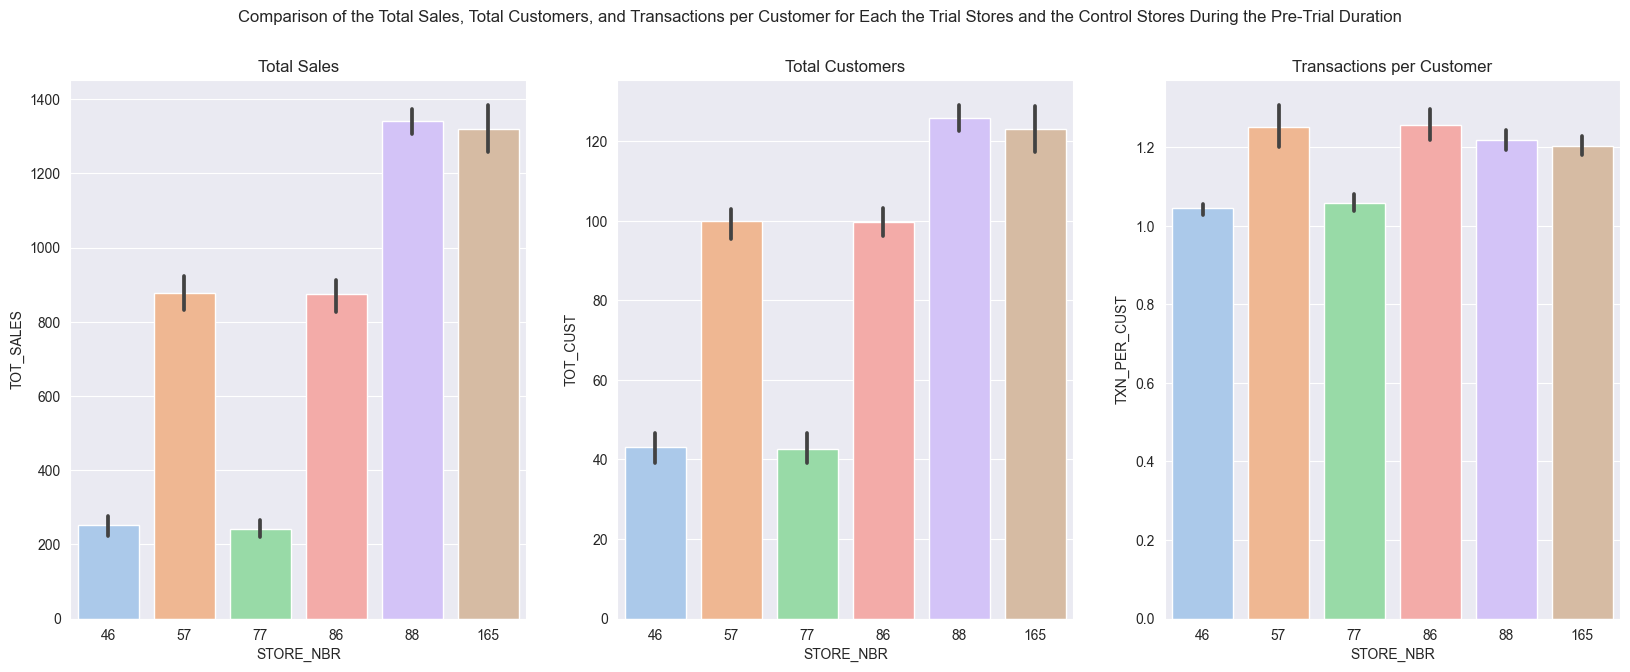

In [24]:
#   Plotting the bar graphs for the total sales, total customers, and transactions per customer for each of the trial stores and the control stores.

sns.set_style("darkgrid")
figure, axis=plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales")
sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers")
sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer")
figure.suptitle("Comparison of the Total Sales, Total Customers, and Transactions per Customer for Each the Trial Stores and the Control Stores During the Pre-Trial Duration")
plt.show()

While the other trial stores performed the same as their corresponding control stores, we can see, however, that STORE_NBR 88 slightly out-performed its control store in all attributes. We can also notice that STORE_NBR 86 and 88 show a significant difference in terms of the total sales, but this isn't the case with STORE_NBR 77, whose sales are considerably less.

Likewise, we can also compare different control stores to each of the trial stores during the trial duration, as well, to find if the total sales are significantly different in the trial duration.

In [25]:
trial_data=dataframe.loc[dataframe.index.get_level_values("YEAR_MONTH")>="2019-02"]  #   Extracting the pandas.DataFrame for the trial duration.
trial_data=trial_data.reset_index()
trial_data

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2019-02,225.4,52,1.057692
1,1,2019-03,192.9,45,1.088889
2,1,2019-04,192.9,42,1.023810
3,1,2019-05,221.4,46,1.108696
4,1,2019-06,174.1,42,1.000000
...,...,...,...,...,...
1295,272,2019-02,395.5,45,1.066667
1296,272,2019-03,442.3,50,1.060000
1297,272,2019-04,445.1,54,1.018519
1298,272,2019-05,314.6,34,1.176471


In [26]:
#   Extracting the pandas.DataFrames for each of the trial stores.

trial_stores_one=trial_data.loc[trial_data.STORE_NBR.isin([77])].reset_index()
trial_stores_two=trial_data.loc[trial_data.STORE_NBR.isin([86])].reset_index()
trial_stores_three=trial_data.loc[trial_data.STORE_NBR.isin([88])].reset_index()

In [27]:
#   Extracting the pandas.DataFrames for each of the control stores.

control_stores_one=trial_data.loc[trial_data.STORE_NBR.isin([46])].reset_index()
control_stores_two=trial_data.loc[trial_data.STORE_NBR.isin([57])].reset_index()
control_stores_three=trial_data.loc[trial_data.STORE_NBR.isin([165])].reset_index()

In [28]:
stores=pd.concat([trial_stores_one, trial_stores_two, trial_stores_three, control_stores_one, control_stores_two, control_stores_three], axis=0)    #   Concatenating all the pandas.DataFrames into one.
stores

,index,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,360,77,2019-02,235.00,45,1.000000
1,361,77,2019-03,278.50,50,1.100000
2,362,77,2019-04,263.50,47,1.021277
3,363,77,2019-05,299.30,55,1.018182
4,364,77,2019-06,264.70,41,1.024390
0,400,86,2019-02,913.20,107,1.289720
1,401,86,2019-03,1026.80,115,1.217391
2,402,86,2019-04,848.20,105,1.200000
3,403,86,2019-05,889.30,104,1.230769
4,404,86,2019-06,838.00,98,1.204082


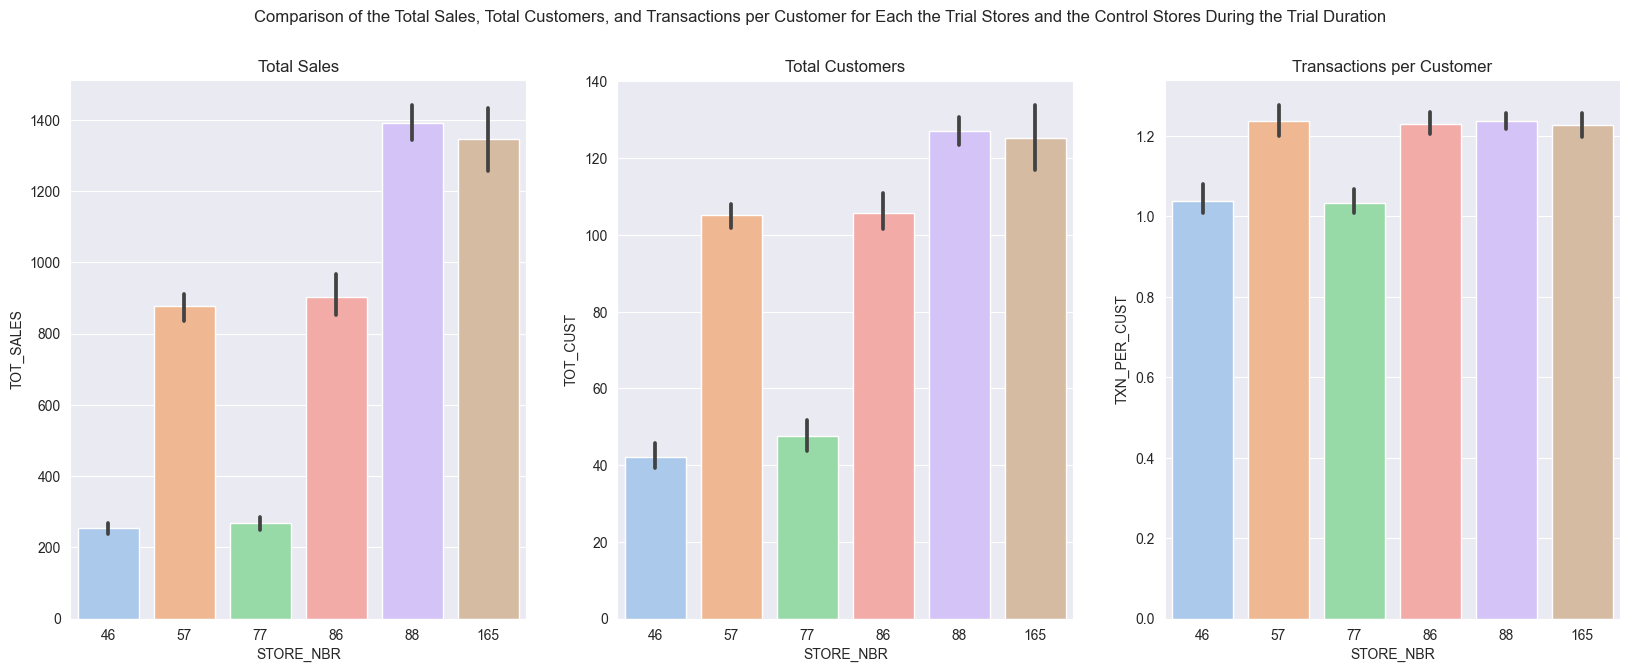

In [29]:
#   Plotting the bar graphs for the total sales, total customers, and transactions per customer for each of the trial stores and the control stores.

sns.set_style("darkgrid")
figure, axis=plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales")
sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers")
sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer")
figure.suptitle("Comparison of the Total Sales, Total Customers, and Transactions per Customer for Each the Trial Stores and the Control Stores During the Trial Duration")
plt.show()

We can, once again, notice that STORE_NBR 88 slightly out-performs its control store, STORE_NBR 165, and still remains the best implementation of the trial of all the trial stores. The driver for this seems to be the purchasing customers rather than purchases per customer, as we can see that with the increase in the total customers, there's also an increase in the total sales almost identically, but the transactions per customer seem to be reasonably high for all the trial stores regardless of the total sales.

### ‣ Conclusion:

- While the other trial stores performed the same as their corresponding control stores, we can see, however, that STORE_NBR 88 slightly out-performed its control store, STORE_NBR 165, in all attributes.

- STORE_NBR 86 and 88 show a significant difference in terms of the total sales, but this isn't the case with STORE_NBR 77, which may be because of the way the trial was implemented for it.

- Due to the maximum difference in the total sales of all the trial stores, STORE_NBR 88 remains the best implementation of the trial.

- The driver for the increase in total sales seems to be the purchasing customers rather than purchases per customer — the more the customers, the higher the sales.